Duplicate key in file PosixPath('/home/runqiu/anaconda3/envs/gurobi312/lib/python3.12/site-packages/matplotlib/mpl-data/matplotlibrc'), line 814 ('font.family: sans-serif')
Duplicate key in file PosixPath('/home/runqiu/anaconda3/envs/gurobi312/lib/python3.12/site-packages/matplotlib/mpl-data/matplotlibrc'), line 815 ('font.sans-serif: SimHei')
Duplicate key in file PosixPath('/home/runqiu/anaconda3/envs/gurobi312/lib/python3.12/site-packages/matplotlib/mpl-data/matplotlibrc'), line 816 ('axes.unicode_minus: False')


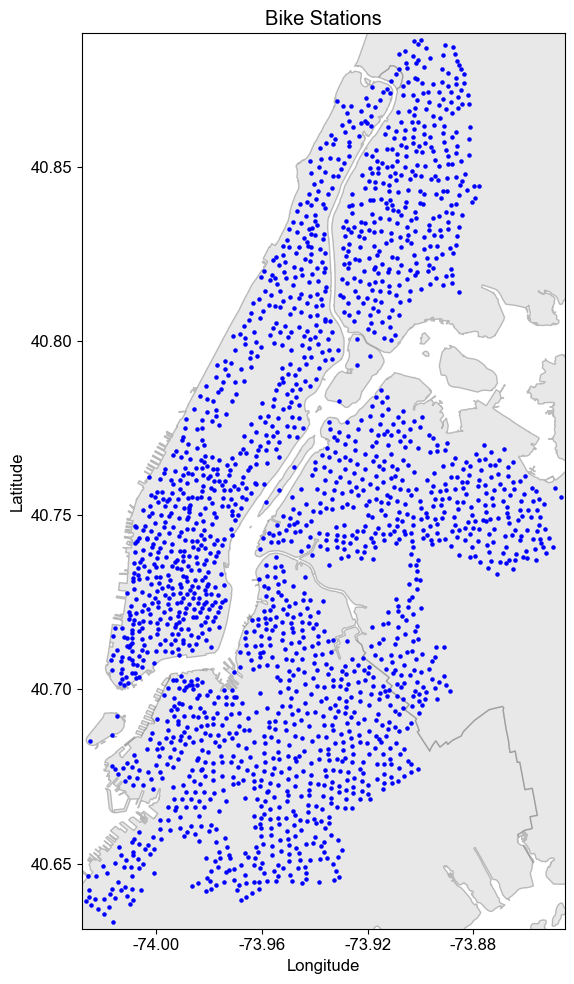

In [1]:
# visualize the Stations using geopandas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.ticker as ticker

# set font to Arial
plt.rcParams['font.family'] = 'Arial'
# set font size to 12
plt.rcParams['font.size'] = 12

nyc_boroughs = gpd.read_file('../data/NYC_map/geo_export_e71b5b09-9d14-4194-aa5b-ef25b204f7bb.shp')
nyc_boroughs = nyc_boroughs.to_crs("EPSG:4326")

# Create a GeoDataFrame from the station_ddf DataFrame
station_ddf = pd.read_json('../data/cleaned_stations.json')
geometry = [Point(xy) for xy in zip(station_ddf['longitude'], station_ddf['latitude'])]

gdf = gpd.GeoDataFrame(station_ddf, geometry=geometry)
# Set the coordinate reference system (CRS) to WGS84
gdf.crs = "EPSG:4326"
# Plot the stations on a map
fig, ax = plt.subplots(figsize=(10, 10))
# Get the bounds of your bike station data
minx, miny, maxx, maxy = gdf.total_bounds

# Add a small buffer around the data (5% padding)
buffer_x = (maxx - minx) * 0.008
buffer_y = (maxy - miny) * 0.008

# Set the map extent
ax.set_xlim(minx - buffer_x, maxx + buffer_x)
ax.set_ylim(miny - buffer_y, maxy + buffer_y)
nyc_boroughs.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.5)
gdf.plot(ax=ax, color='blue', markersize=5)
# Add a title and labels
ax.set_title('Bike Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Add these lines before plt.show()
ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Fewer ticks
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  # Fewer decimals
# plt.xticks(rotation=45)  # Rotate labels
plt.tight_layout()  # Adjust spacing to make room for rotated labels
# Show the plot
plt.savefig('bike_stations_map.png', dpi=300, bbox_inches='tight')

In [15]:
import matplotlib as mpl
print("Config file locations:", mpl.matplotlib_fname())
print("All paths checked:", mpl.get_configdir())


Config file locations: /home/runqiu/anaconda3/envs/gurobi312/lib/python3.12/site-packages/matplotlib/mpl-data/matplotlibrc
All paths checked: /home/runqiu/.config/matplotlib


In [13]:
nyc_boroughs = gpd.read_file('../data/NYC_map/geo_export_e71b5b09-9d14-4194-aa5b-ef25b204f7bb.shp')
nyc_boroughs = nyc_boroughs.to_crs("EPSG:4326")

nyc_boroughs['boroname'].unique()

array(['Brooklyn', 'Staten Island', 'Manhattan', 'Bronx', 'Queens'],
      dtype=object)

In [1]:
import pandas as pd
import numpy as np

def create_station_interval_table():
    print("Loading data...")
    # Load the filtered data
    trips_df = pd.read_csv('../data/cleaned_trips.csv')
    with open('../data/cleaned_stations.json', 'r') as f:
        stations_data = pd.read_json(f)
    
    # Convert timestamps to datetime
    print("Processing timestamps...")
    trips_df['started_at'] = pd.to_datetime(trips_df['started_at'], errors='coerce')
    trips_df['ended_at'] = pd.to_datetime(trips_df['ended_at'], errors='coerce')
    trips_df['weekdays'] = trips_df['started_at'].dt.dayofweek
    # only preserve the weekdays (From Monday to Friday)
    trips_df = trips_df[trips_df['weekdays'] < 5]

    # Extract hour and minute
    trips_df['start_hour'] = trips_df['started_at'].dt.hour
    trips_df['start_minute'] = trips_df['started_at'].dt.minute
    trips_df['end_hour'] = trips_df['ended_at'].dt.hour
    trips_df['end_minute'] = trips_df['ended_at'].dt.minute
    
    # Create interval bins (0 for 00:00-00:30, 1 for 00:30-01:00, etc.)
    trips_df['start_interval'] = trips_df['start_hour'] * 2 + (trips_df['start_minute'] >= 30).astype(int)
    trips_df['end_interval'] = trips_df['end_hour'] * 2 + (trips_df['end_minute'] >= 30).astype(int)
    
    # Initialize the result dataframe with all stations
    all_stations = stations_data['station_id'].tolist()
    
    # Create 30-minute interval labels
    intervals = []
    for hour in range(24):
        for minute in [0, 30]:
            interval_start = f"{hour:02d}:{minute:02d}"
            interval_end = f"{hour:02d}:{minute+30:02d}" if minute == 0 else f"{(hour+1) % 24:02d}:00"
            intervals.append(f"{interval_start}-{interval_end}")
    
    # Initialize the result dataframe
    result_df = pd.DataFrame(index=all_stations)
    
    # Process in batches to avoid memory issues (if needed)
    print("Processing rental counts...")
    
    # Compute rental counts for each interval
    for interval_idx in range(48):  # 48 intervals in a day
        interval_label = intervals[interval_idx]
        
        # Count rentals for this interval
        rentals = trips_df[trips_df['start_interval'] == interval_idx].groupby('start_station_id').size()
        result_df[f'rentalrate_{interval_label}'] = result_df.index.map(rentals).fillna(0)
        result_df[f'rentalrate_{interval_label}'] = result_df[f'rentalrate_{interval_label}'] / 30 / 20
        # preserve 5 decimal places
        result_df[f'rentalrate_{interval_label}'] = result_df[f'rentalrate_{interval_label}'].round(5)
        
        # Count returns for this interval
        returns = trips_df[trips_df['end_interval'] == interval_idx].groupby('end_station_id').size()
        result_df[f'returnrate_{interval_label}'] = result_df.index.map(returns).fillna(0)
        result_df[f'returnrate_{interval_label}'] = result_df[f'returnrate_{interval_label}'] / 30 / 20
        # preserve 5 decimal places
        result_df[f'returnrate_{interval_label}'] = result_df[f'returnrate_{interval_label}'].round(5)

    
    # Add station names for reference
    station_names = dict(zip(stations_data['station_id'], stations_data['name']))
    result_df.insert(0, 'station_name', result_df.index.map(station_names))
    
    print("Saving results...")
    result_df.to_csv('../data/station_30min_intervals.csv')
    print(f"Created table with {len(result_df)} stations and {len(result_df.columns)} columns")
    
    return result_df

station_interval_table = create_station_interval_table()


Loading data...
Processing timestamps...
Processing rental counts...
Saving results...
Created table with 2113 stations and 97 columns


In [2]:
import dask.dataframe as dd

ddf = dd.read_csv('../data/station_30min_intervals.csv', dtype={'start_station_id': str, 'end_station_id': str})

# set the Unnamed: 0 column as station_id
ddf = ddf.rename(columns={'Unnamed: 0': 'station_id'})

station_info = pd.read_json('../data/cleaned_stations.json')

# supplement the 'capacity' column with the station_info dataframe
ddf = ddf.merge(station_info[['station_id', 'capacity']], on='station_id', how='left')

ddf.to_csv('../data/station_30min_intervals_with_capacity.csv', index=False, single_file=True)



['/home/runqiu/projects/ctbk-data/data/station_30min_intervals_with_capacity.csv']

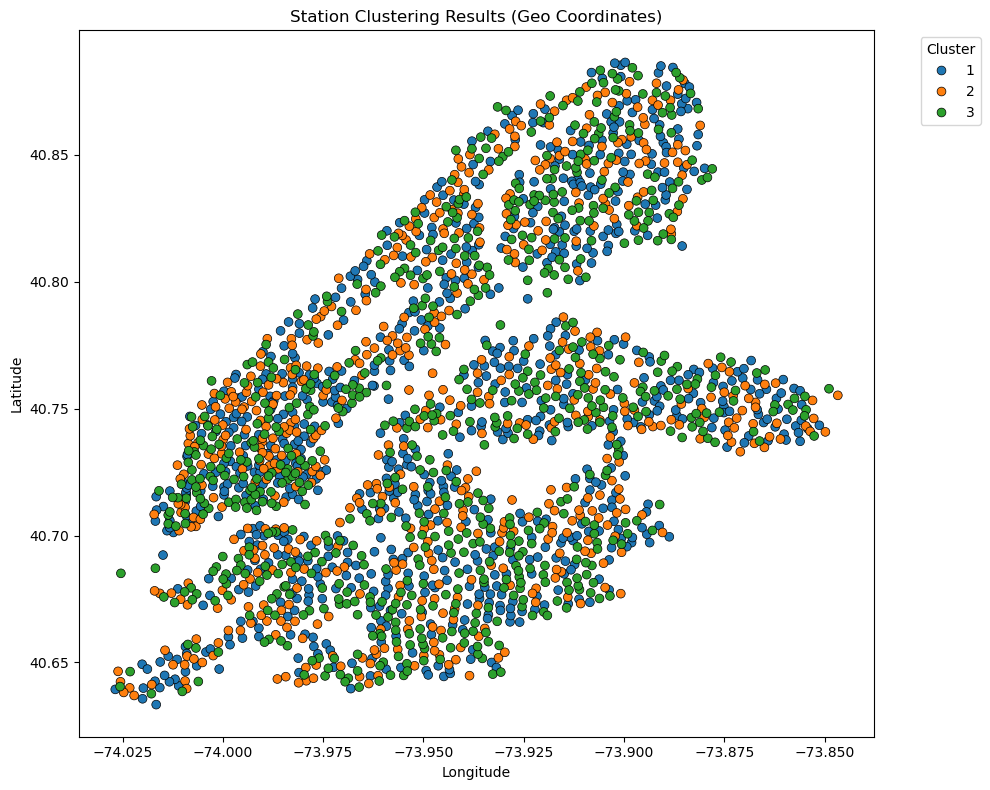

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load clustering results
clustering_df = pd.read_csv('../build/real_stations_clustering.csv')

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=clustering_df,
    x='Longitude',
    y='Latitude',
    hue='Cluster',
    palette='tab10',
    s=40,
    edgecolor='k',
    linewidth=0.5
)
plt.title('Station Clustering Results (Geo Coordinates)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()